Name: Aditya Saripalli  
Roll No: 20173071

In [1]:
# Importing all the necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Prepare breast cancer data set for perceptron computation
def prepare_bcw_data_set():
    data_set = []
    # preparing a list of list data structure
    data_file = open("./breast-cancer-wisconsin.data", "r")
    
    for line in data_file.readlines():
        # removing missing records
        if "?" in line.split(","):
            continue
        line = [float(i) for i in line.rstrip().split(",")]
        # value holders for signum function 
        if line[-1] == 2:
            line[-1] = 1;
        else:
            line[-1] = -1;
        # setting the bias multipliers in data set
        line[0] = 1;
        # store the record in data set
        data_set.append(line)

    data_file.close()
    return np.array(data_set)

In [3]:
# Prepare ionosphere data set for perceptron computation
def prepare_ion_data_set():
    data_set = []
    # preparing a list of list data structure
    data_file = open("./ionosphere.data", "r")
    
    for line in data_file.readlines():
        line_tokens = line.rstrip().split(",")
        # values holders for signum function
        if line_tokens[-1] == "g":
            line_tokens[-1] = "1";
        else:
            line_tokens[-1] = "-1";
        line = [float(i) for i in line_tokens]
        # store the record in data set
        data_set.append(line)

    # adding the bias multipliers in data set
    data_set = np.array(data_set)
    n_datasets = data_set.shape[0]
    bias_vector = np.ones(n_datasets).reshape(n_datasets,1)
    data_set = np.hstack((bias_vector, data_set))
    
    data_file.close()
    return data_set

In [4]:
# Divide the complete data set into k-fold training sets: here k = 10
# return a dictionary of key=k_fold_index and value=sub_data_set
def prepare_k_fold_training_sets(data_set, k):
    # get the dimensions of the data set
    n_datasets, n_features = data_set.shape
    # divide the data set into k = 10 fold
    k_fold_size = int(n_datasets / 10)
    # dictionary to store the k-fold training sets
    k_training_sets = {}

    # create a dictionory of key=k_fold_index and value=partial_data_set
    for i in range(k):
        if i < k-1:
            k_training_sets[i] = np.array(data_set[i*k_fold_size : (i+1)*k_fold_size,]) 
        else:
            # for the last iteration take all the data left
            k_training_sets[i] = np.array(data_set[i*k_fold_size :,])

    return k_training_sets

In [5]:
# Training perceptron weights
def train_p_weights(training_data_set, weights):
    # separating features and class labels
    data_set_features = np.array(training_data_set[:,:-1])
    data_set_labels   = np.array(training_data_set[:,[-1]])
    # get the dimensions of the data set
    n_datasets, n_features = data_set_features.shape
    # learning rate for perceptron is 1.0
    learning_rate = 1.0

    for i in range(n_datasets):
        # calculate the dot product y_t(w_t.x_t)
        if ( np.dot(data_set_features[i], weights ) * data_set_labels[i]) <= 0:
            weights += learning_rate * data_set_labels[i] * data_set_features[i]

    return weights

In [6]:
# Training voted perceptron weights
def train_vp_weights(training_data_set, weights):
    # separating features and class labels
    data_set_features = np.array(training_data_set[:,:-1])
    data_set_labels   = np.array(training_data_set[:,[-1]])

    n_datasets, n_features = data_set_features.shape
    # learning rate for perceptron is 1.0
    learning_rate = 1.0
    # arrays to store the list of weight vectors
    t_votes = np.empty((0,1))
    t_weights = np.empty((0,n_features))
    # default vote
    votes = 1.0
    
    for i in range(n_datasets):
        # calculate the dot product y_t(w_t.x_t)
        if (np.dot(data_set_features[i], weights) * data_set_labels[i]) <= 0:
            # in case of a misclassification
            # add the weight vector to the array of weight vectors
            # and its corresponding votes to array of votes
            t_weights = np.vstack((t_weights, weights))
            t_votes = np.vstack((t_votes, [votes]))
            # create a new weight vector and assign a default vote of 1.0
            weights += learning_rate * data_set_labels[i] * data_set_features[i]
            votes = 1.0
        else:
            # weight vector has survived hence increment the vote
            votes = votes + 1.0

    # if at this point the t_weights array is still empty it means the weight
    # vector supplied was good for the entire training set. Thus we update
    # the t_weights array and its corresponding votes count accordingly
    if t_weights.size == 0:
        t_weights = np.vstack((t_weights, weights))
        t_votes = np.vstack((t_votes, [votes]))

    return weights, votes, t_weights, t_votes

In [7]:
# Perceptron Algorithm
def perceptron(data_set, num_epochs):
    # dividing the data for k-fold cross validation
    # k_training_sets is a dictionary of all the k-fold data sets
    k = 10
    k_training_sets = prepare_k_fold_training_sets(data_set, k)
    p_accuracy = np.array([])

    for i in range(k):
        # initialize the weight vector
        weights = np.zeros(data_set.shape[1] - 1)
        # store the validation data set
        validation_data_set = k_training_sets[i]
        # each epochs runs for complete training data set
        for epoch in range(num_epochs):
            for j in range(k):
                if j != i:
                    weights = train_p_weights(k_training_sets[j] , weights)
        # cross validation to find k-fold accuracies
        predicted_values = []
        expected_values  = []
        # computing predicted values
        for row in validation_data_set:
            if (np.dot(row[:-1], weights)) <= 0:
                predicted_values.append(-1.0)
            else:
                predicted_values.append(1.0)
            expected_values.append(row[-1])
        # computing accuracies
        num_correct_predictions = 0.0
        for predicted_value, expected_value in zip(predicted_values, expected_values):
            if predicted_value == expected_value:
                num_correct_predictions += 1;
        vdata_size = validation_data_set.shape[0]
        p_accuracy = np.append(p_accuracy, [(num_correct_predictions / vdata_size)])

    # compute the mean accuracy for the current epoch run
    mean_accuracy = p_accuracy.mean()
    return mean_accuracy

In [8]:
# Voted Perceptron Algorithm
def voted_perceptron(data_set, num_epochs):
    # dividing the data for k-fold cross validation
    # k_training_sets is a dictionary of all the k-fold data sets
    k = 10
    k_training_sets = prepare_k_fold_training_sets(data_set, k)
    p_accuracy = np.array([])
    n_features = data_set.shape[1] - 1

    for i in range(k):
        # initialize the weight vector
        weights = np.zeros(n_features)
        votes = 1.0
        # data structures to store the voted weight vectors, their weights
        # and accuracies. Initialize the list of weight vectors and list
        # of corresponding votes
        vp_weights = np.empty((0, n_features))
        vp_votes = np.empty((0,1))

        # store the validation data set
        validation_data_set = k_training_sets[i]
        # each epochs runs for complete training data set
        for epoch in range(num_epochs):
            for j in range(k):
                if j != i:
                    weights,votes,t_weights,t_votes = train_vp_weights(k_training_sets[j],
                                                                          weights)
                    vp_weights = np.insert(vp_weights, vp_weights.shape[0],
                                           t_weights, axis=0)
                    vp_votes = np.insert(vp_votes, vp_votes.shape[0],
                                         t_votes, axis=0)
            else:
                #update the last weight vector and votes before next epoch run
                vp_weights = np.insert(vp_weights, vp_weights.shape[0],
                                       weights, axis=0)
                vp_votes = np.insert(vp_votes, vp_votes.shape[0],
                                     [votes], axis=0)
            
        # Cross validation to find k-fold accuracies
        predicted_values = []
        expected_values  = []
        for row in validation_data_set:
            inner_product = 0.0
            predicted_value = 0.0
            # Calculate the inner product and the predicted value using
            # the complete list of weight vectors their corresponding votes
            for w_vector, w_vote in zip(vp_weights, vp_votes):
                inner_product = np.dot(w_vector, row[:-1])
                if inner_product > 0:
                    predicted_value += w_vote[0]
                else:
                    predicted_value -= w_vote[0]

            if predicted_value > 0:
                predicted_values.append(1.0)
            else:
                predicted_values.append(-1.0)
            expected_values.append(row[-1])

        # computing accuracy
        num_correct_predictions = 0.0
        for predicted_value, expected_value in zip(predicted_values, expected_values):
            if predicted_value == expected_value:
                num_correct_predictions += 1;
        vdata_size = validation_data_set.shape[0]
        p_accuracy = np.append(p_accuracy, [(num_correct_predictions / vdata_size)])
    
    # compute the mean accuracy for the current epoch run
    mean_accuracy = p_accuracy.mean()
    return mean_accuracy

In [9]:
# Plotting Breast Cancer Data
def plot_breast_cancer_data(epochs_run_list,
                            p_mean_accuracies,
                            vp_mean_accuracies):
    plt.title("Breast Cancer Wisconsin")
    plt.xlabel('Number of Epochs')
    plt.ylabel('Perceptron Accuracies')

    plt.plot(epochs_run_list,
             p_mean_accuracies,
             label="Vanilla Perceptron")
    
    plt.plot(epochs_run_list,
             vp_mean_accuracies,
             label="Voted Perceptron")
    
    plt.legend(loc=4)
    plt.show()

In [10]:
# Plotting Ionosphere Data
def plot_ionosphere_data(epochs_run_list,
                         p_mean_accuracies,
                         vp_mean_accuracies):
    plt.title("Ionosphere Data")
    plt.xlabel('Number of Epochs')
    plt.ylabel('Perceptron Accuracies')

    plt.plot(epochs_run_list,
             p_mean_accuracies,
             label="Vanilla Perceptron")
    
    plt.plot(epochs_run_list,
             vp_mean_accuracies,
             label="Voted Perceptron")
    
    plt.legend(loc=4)
    plt.show()

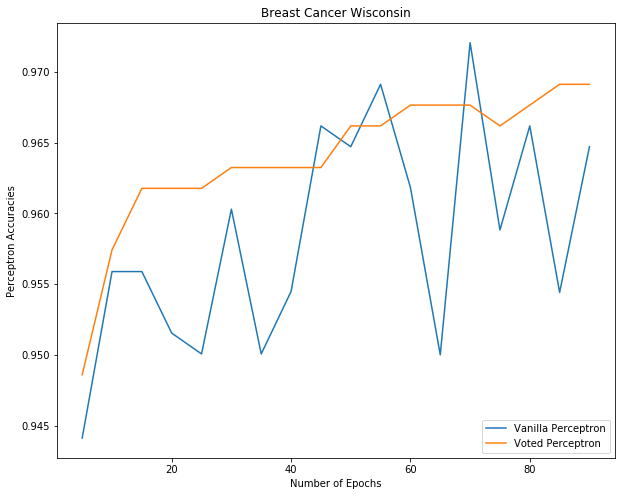

In [11]:
##################################################################
#                      Breast Cancer dataset                     #
##################################################################
epochs_run_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
p_mean_accuracies = []
vp_mean_accuracies = []

# prepare the data set
data_set = prepare_bcw_data_set()

# run Vanilla Perceptron Algorithm
for epoch in epochs_run_list:
    p_mean_accuracy = perceptron(data_set, epoch)
    p_mean_accuracies.append(p_mean_accuracy)

# running Voted Perceptron Algorithm
for epoch in epochs_run_list:
    p_mean_accuracy = voted_perceptron(data_set, epoch)
    vp_mean_accuracies.append(p_mean_accuracy)

# plot the data comparing both the approaches
plot_breast_cancer_data(epochs_run_list,
                        p_mean_accuracies,
                        vp_mean_accuracies)

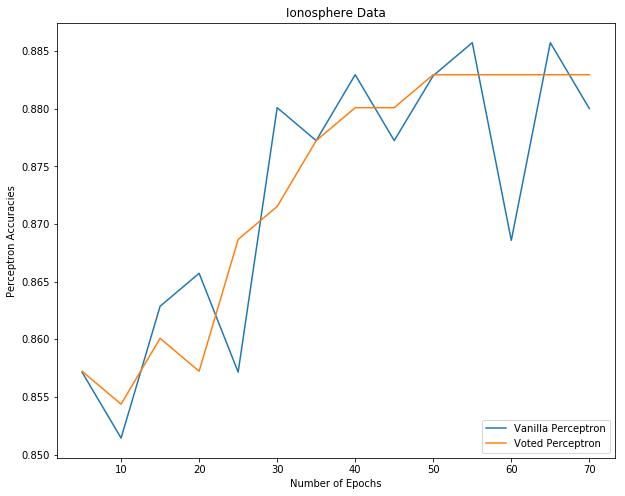

In [12]:
##################################################################
#                       Ionosphere Dataset                       #
##################################################################
epochs_run_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]
p_mean_accuracies = []
vp_mean_accuracies = []

# prepare the data set
data_set = prepare_ion_data_set()

# run Vanilla Perceptron Algorithm
for epoch in epochs_run_list:
    p_mean_accuracy = perceptron(data_set, epoch)
    p_mean_accuracies.append(p_mean_accuracy)

# running Voted Perceptron Algorithm
for epoch in epochs_run_list:
    p_mean_accuracy = voted_perceptron(data_set, epoch)
    vp_mean_accuracies.append(p_mean_accuracy)

# plot the data comparing both the approaches
plot_ionosphere_data(epochs_run_list,
                     p_mean_accuracies,
                     vp_mean_accuracies)

Observations:
=============

1. Breast cancer data set:
--------------------------
The "Breast Cancer Wisconsin" plot shows the values till 100 epochs.  
-> With Vanilla Perceptron, the plot between number of epochs vs mean accuracies donot converge even for a run till 100 epochs. The mean accuracies values are between 94% to 97%.  
-> With Voted Perceptron the mean accuracies are between 90% to 96.6%. The plot between number of epochs vs mean accuracies shows convergence after post 90 epochs with 96.6% accuracy.

2. Ionosphere data set:
-----------------------
The "Ionosphere Data" plot shows the values till 100 epochs.  
-> With Vanilla Perceptron, the plot between number of epochs vs mean accuracies donot converge even for a run till 100 epochs. The mean accuracies values are between 85% to 90%.  
-> With Voted Perceptron the mean accuracies are between 82% to 86%. The plot between number of epochs vs mean accuracies shows convergence after post 70 epochs with 84.6% accuracy.  
  
  
On both the data sets, we can observe that the Voted Perceptron algorithm do converge post some epoch value, but with the Vanilla Perceptron algorithm convergence in not guranteed though it gives better accuracy percentage with some epochs.